In [1]:
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-06-22 11:28:24.188275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Load the data

DIR_inv = 'Data/nature_cls/train_data'
folders = os.listdir(DIR_inv)

In [8]:
import shutil

d = []
for c in folders:
    if c != 'Agg_images':
        classes_path = os.path.join(DIR_inv, c)

        img_files = os.listdir(classes_path)
        
        for img in img_files:
            
            img_src = os.path.join(DIR_inv, c, img)
            img_dest = os.path.join('Data/nature_cls', 'Agg_images', img)

            shutil.copy(img_src, img_dest)

            d.append(
                {
                    'filename': img,
                    'class': c
                }
            )

train = pd.DataFrame(d)
train.to_csv(os.path.join('Data/nature_cls', 'train.csv'))

In [3]:
train = pd.read_csv('Data/nature_cls/train.csv').iloc[:,1:]

train['code'] = train['class'].astype('category').cat.codes
print(len(train.code.unique()), train.shape)
train.head()

3 (2966, 3)


,filename,class,code
0,10134.jpg,Nature,0
1,1.jpg,Nature,0
2,10135.jpg,Nature,0
3,10.jpg,Nature,0
4,10136.jpg,Nature,0


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2, random_state=420)

In [5]:
def createModel(Model_name, final_classes):
    vgg_model = Model_name(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

    for layer in vgg_model.layers:
        layer.trainable=False
        
    input = Input(shape=(224, 224, 3), name = 'image_input')
    output_vgg19_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg19_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(final_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

In [6]:
def initialize_model_inv(Model_name, datagen_train,datagen_valid, final_classes):
    model = createModel(Model_name, final_classes)

    train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                            directory=os.path.join('Data/nature_cls/','Agg_images'),
                                            x_col="filename",
                                            y_col="class",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                            directory=os.path.join('Data/nature_cls/','Agg_images'),
                                            x_col="filename",
                                            y_col="class",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    return model, train_generator, valid_generator, STEP_SIZE_TRAIN, STEP_SIZE_VALID, es

In [11]:
def set_up_augmentation(
    rotation_range=0,
    guassian_blur=0, # vertical shift
    zoom = 0,
    horizontal_flip=0
):
    import imgaug as ia
    import imgaug.augmenters as iaa

    ia.seed(1411)

    seq = iaa.Sequential([
        iaa.Fliplr(horizontal_flip), # horizontal flips
        iaa.Crop(percent=(0, zoom)), # random crops
        # iaa.LinearContrast((0.75, 1.5)),
        # Small gaussian blur with random sigma between 0 and 1.0.
        # But we only blur about 25% of all images.
        iaa.Sometimes(
            guassian_blur,
            iaa.GaussianBlur(sigma=(0, 1.0))
        ),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Sometimes(
        0.30, 
        iaa.Affine(rotate=(-rotation_range, rotation_range))
        )
    ], random_order=True) # apply augmenters in random order


    datagen_train = ImageDataGenerator(rescale=1./255.,
        preprocessing_function=seq.augment_image
    )

    datagen_valid = ImageDataGenerator(rescale=1./255)

    return datagen_train, datagen_valid

In [9]:
def printHistory(history, filename):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('VGG-19')
    
    
    ax1.set_title('Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    
    ax2.set_title('Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])

    plt.savefig(filename)

    plt.show()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              3355

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


74/74 [==============================] - 31s 414ms/step - loss: 0.8345 - accuracy: 0.7159 - val_loss: 0.4933 - val_accuracy: 0.7795
Epoch 2/50
74/74 [==============================] - 11s 153ms/step - loss: 0.3578 - accuracy: 0.8823 - val_loss: 0.3982 - val_accuracy: 0.8472
Epoch 3/50
74/74 [==============================] - 11s 146ms/step - loss: 0.2325 - accuracy: 0.9270 - val_loss: 0.3251 - val_accuracy: 0.8854
Epoch 4/50
74/74 [==============================] - 11s 142ms/step - loss: 0.1860 - accuracy: 0.9309 - val_loss: 0.3139 - val_accuracy: 0.8854
Epoch 5/50
74/74 [==============================] - 11s 145ms/step - loss: 0.1305 - accuracy: 0.9571 - val_loss: 0.3083 - val_accuracy: 0.9010
Epoch 6/50
74/74 [==============================] - 11s 143ms/step - loss: 0.0770 - accuracy: 0.9730 - val_loss: 0.3571 - val_accuracy: 0.8889
Epoch 7/50
74/74 [==============================] - 11s 144ms/step - loss: 0.0902 - accuracy: 0.9685 - val_loss: 0.3716 - val_accuracy: 0.8976
Epoch 8/50

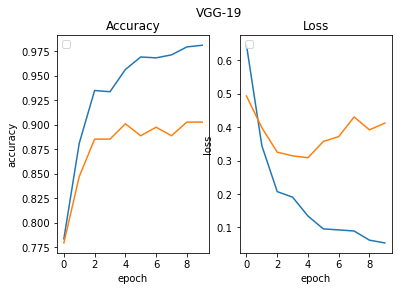

In [18]:
# Training 
datagen_train, datagen_valid = set_up_augmentation(

)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model_inv(applications.VGG19, datagen_train, datagen_valid, 3)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/nature_vgg.jpg')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
batch_normalization_215 (Bat (None, 5, 5, 1536)        6144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 1536)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              5662

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


74/74 [==============================] - 84s 187ms/step - loss: 0.6828 - accuracy: 0.7860 - val_loss: 0.5209 - val_accuracy: 0.8976
Epoch 2/50
74/74 [==============================] - 82s 1s/step - loss: 0.2155 - accuracy: 0.9242 - val_loss: 0.4520 - val_accuracy: 0.8976
Epoch 3/50
74/74 [==============================] - 11s 145ms/step - loss: 0.1671 - accuracy: 0.9437 - val_loss: 0.4046 - val_accuracy: 0.9184
Epoch 4/50
74/74 [==============================] - 11s 144ms/step - loss: 0.1349 - accuracy: 0.9595 - val_loss: 0.3160 - val_accuracy: 0.9149
Epoch 5/50
74/74 [==============================] - 11s 146ms/step - loss: 0.1088 - accuracy: 0.9654 - val_loss: 0.3374 - val_accuracy: 0.9115
Epoch 6/50
74/74 [==============================] - 11s 148ms/step - loss: 0.0681 - accuracy: 0.9777 - val_loss: 0.3284 - val_accuracy: 0.9253
Epoch 7/50
74/74 [==============================] - 11s 147ms/step - loss: 0.0615 - accuracy: 0.9797 - val_loss: 0.3990 - val_accuracy: 0.9201
Epoch 8/50
74

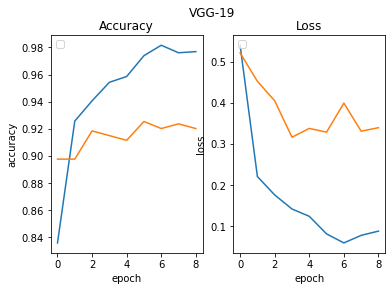

In [19]:
# Training 
datagen_train, datagen_valid = set_up_augmentation(

)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model_inv(applications.InceptionResNetV2, datagen_train, datagen_valid, 3)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/nature_incep.jpg')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
batch_normalization_219 (Bat (None, 7, 7, 2048)        8192      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 2048)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              1342

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


74/74 [==============================] - 113s 827ms/step - loss: 0.6435 - accuracy: 0.7929 - val_loss: 0.5876 - val_accuracy: 0.8924
Epoch 2/50
74/74 [==============================] - 10s 136ms/step - loss: 0.1960 - accuracy: 0.9310 - val_loss: 0.3913 - val_accuracy: 0.8993
Epoch 3/50
74/74 [==============================] - 10s 135ms/step - loss: 0.0743 - accuracy: 0.9753 - val_loss: 0.3410 - val_accuracy: 0.9201
Epoch 4/50
74/74 [==============================] - 10s 138ms/step - loss: 0.0407 - accuracy: 0.9862 - val_loss: 0.4049 - val_accuracy: 0.9062
Epoch 5/50
74/74 [==============================] - 10s 132ms/step - loss: 0.0610 - accuracy: 0.9826 - val_loss: 0.3870 - val_accuracy: 0.9045
Epoch 6/50
74/74 [==============================] - 10s 137ms/step - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.3801 - val_accuracy: 0.9115
Epoch 7/50
74/74 [==============================] - 10s 135ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.3806 - val_accuracy: 0.9132
Epoch 8/5

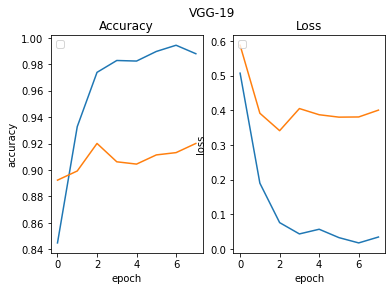

In [20]:
# Training 
datagen_train, datagen_valid = set_up_augmentation(

)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model_inv(applications.ResNet50V2, datagen_train, datagen_valid, 3)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/nature_res.jpg')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
batch_normalization_410 (Bat (None, 5, 5, 1536)        6144      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 1536)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              5662

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
74/74 [==============================] - 31s 272ms/step - loss: 0.7162 - accuracy: 0.7537 - val_loss: 0.5688 - val_accuracy: 0.8507
Epoch 2/50
74/74 [==============================] - 18s 238ms/step - loss: 0.4119 - accuracy: 0.8635 - val_loss: 0.4337 - val_accuracy: 0.8767
Epoch 3/50
74/74 [==============================] - 17s 230ms/step - loss: 0.3646 - accuracy: 0.8753 - val_loss: 0.3435 - val_accuracy: 0.9062
Epoch 4/50
74/74 [==============================] - 17s 229ms/step - loss: 0.3767 - accuracy: 0.8731 - val_loss: 0.3043 - val_accuracy: 0.9219
Epoch 5/50
74/74 [==============================] - 17s 224ms/step - loss: 0.2981 - accuracy: 0.9040 - val_loss: 0.3381 - val_accuracy: 0.9062
Epoch 6/50
74/74 [==============================] - 17s 235ms/step - loss: 0.3490 - accuracy: 0.8755 - val_loss: 0.2660 - val_accuracy: 0.9184
Epoch 7/50
74/74 [==============================] - 16s 222ms/step - loss: 0.2787 - accuracy: 0.9020 - val_loss: 0.3316 - val_accuracy: 0.9219

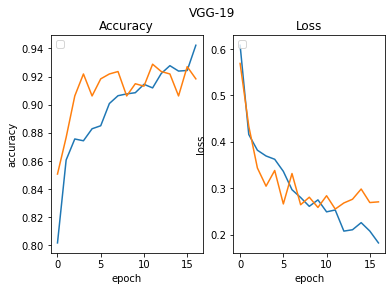

In [12]:
# Training 
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=25,
    guassian_blur=0.25,
    zoom = 0.2,
    horizontal_flip=0.5
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model_inv(applications.InceptionResNetV2, datagen_train, datagen_valid, 3)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/nature_incep_final.jpg')
model.save("models/nature_cls.h5")

In [13]:
# get predict prob and label 
ypred = model.predict_generator(valid_generator)

y_true = valid_generator.classes
ypred = np.argmax(ypred, axis=1)

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [14]:
print('Classification Report')
print(classification_report(y_true, ypred))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       203
           1       0.91      0.94      0.92       233
           2       0.93      0.87      0.90       158

    accuracy                           0.93       594
   macro avg       0.93      0.92      0.93       594
weighted avg       0.93      0.93      0.93       594



Confusion Matrix
[[195   6   2]
 [  5 220   8]
 [  4  17 137]]


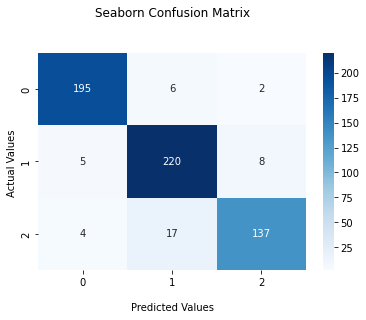

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, ypred)
print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.savefig('output/nature_cls_confusion_M')

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Now we predict the validation iimages one by one to ensure they match
from tqdm import tqdm
tqdm.pandas()

def predict_img(img):
  # example of converting an image with the Keras API
  from tensorflow.keras.preprocessing.image import load_img
  from tensorflow.keras.preprocessing.image import img_to_array

  img_path = os.path.join(DIR_inv, 'Agg_images', img)
  image = np.expand_dims(img_to_array(load_img(img_path, target_size=(224, 224))) / 255, axis=0)
  pred = model.predict(image)
  
  return np.argmax(pred, axis=1)[0]

test['prediction'] = test.filename.progress_map(lambda x: predict_img(x))
test